In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Atividade 1

In [2]:
## Entradas:
### s0 -> valor inicial
### sf -> array com 2 valores finais sf[0] = heads, sf[1] = tails
### t -> fração a ser dividida do tempo
### probs -> array com ptil e qtil
### r -> taxa de juros
### k -> valor de payoff do contrato
### tipo -> tipo do contrato: 0 = call, 1 = put
def binomial(s0,sf,t,probs,r,k,tipo=0):
    # definindo u e d e neutra-riscos
    u = sf[0]/s0
    d = sf[1]/s0
    p_til = probs[0]
    q_til = probs[1]
    t_int = int(t**(-1))
    
    # esperança e desvio padrão do modelo
    mi = p_til*u + q_til * d
    sig = np.sqrt(p_til*q_til*(u-d)**2)
    
    # discretizando ainda mais o tempo para garantir não arbitragem
    M0 = 1+(sig/mi)**2
    M1 = ((1+r)/mi)
    while (1-M1**t)**2 >= (M0**t-1): t = t/2

    # esperança e desvio padrão discretizados
    mi_t = mi**t
    sig_t = np.sqrt((mi**2 + sig**2)**t - (mi**2)**t) 
    # up & down & taxa de juros discretizados
    u_disc = mi_t + sig_t
    d_disc = mi_t - sig_t
    r_disc = (1+r)**t -1

    # garantia de não arbitragem
    assert(d_disc < 1+r_disc and 1+r_disc <  u_disc)
    
    # gerando os valores finais da ação
    Sf = []
    for i in range(t_int):
        Sf.append(s0*u_disc**(t_int-i-1)*d_disc**(i))
    
    # gerando os valores finais do contrato com payoff
    def payoff(s):
        ## Faz um call
        if tipo == 0:
            aux = [i - k if i > k else 0 for i in Sf]
        ## Faz um put
        else:
            aux = [k - i if k > i else 0 for i in Sf]
        return aux
    
    # metódo para calcular v_{n-1} a partir de v_{n}(H) e v_{n}(T)
    def vprev(v_h,v_t):
        v_p = (1/(1+r_disc))*(p_til*v_h + q_til*v_t)
        return (v_p)
    
    # Criando array de Valores do contrato
    Vf = payoff(Sf)
    Vs = [Vf]
    
    # percorrendo e preenchendo os valores de V até V_0
    for j in range(t_int-1):
        aux = []
        for i in range(len(Vs[-1])-1):
            aux.append(vprev(Vs[-1][i],Vs[-1][i+1]))
        Vs.append(aux)
    
    # retorna Todos os valores de contrato e os valores finais da ação
    return Vs,Sf

In [3]:
binomial(4,[8,2],1/4,[1/2,1/2],1/4,5,0)[0]

[[4.979032264304619, 0.5807356147419425, 0, 0],
 [2.629051909806835, 0.27461291734574655, 0.0],
 [1.3730583228186053, 0.12985643115181125],
 [0.7106845088072969]]

In [4]:
binomial(4,[8,2],1/4,[1/2,1/2],1/4,5,1)[0]

[[0, 0, 1.8789949589546282, 3.2545898715395354],
 [0.0, 0.8885218578953032, 2.427522388772923],
 [0.4201560457601976, 1.5680605106848662],
 [0.9401695625695541]]

In [5]:
vs_call = []
vs_put = []
for n in range(1,13):
    vs_call.append(binomial(4,[8,2],1/2**n,[1/2,1/2],1/4,5,0)[0][-1])
    vs_put.append(binomial(4,[8,2],1/2**n,[1/2,1/2],1/4,5,1)[0][-1])

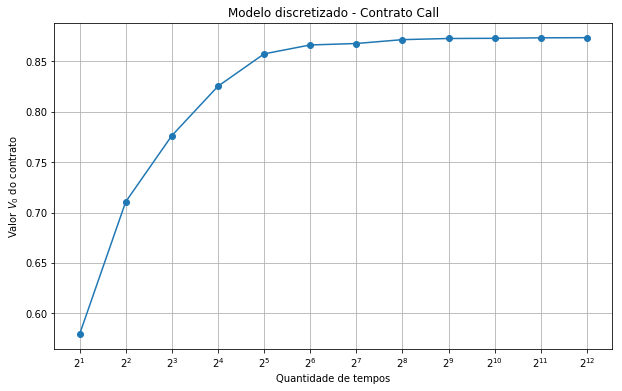

In [6]:
ns = np.linspace(1,12,12)
lbls = ['$2^{'+ str(i) + '}$' for i in range(1,13)]
plt.figure(figsize=(10,6))
plt.plot(ns,vs_call,marker='o')
plt.title('Modelo discretizado - Contrato Call')
plt.xticks(ns,labels=lbls)
plt.yticks()
plt.xlabel('Quantidade de tempos')
plt.ylabel('Valor ${V_0}$ do contrato')
plt.grid()
plt.show()

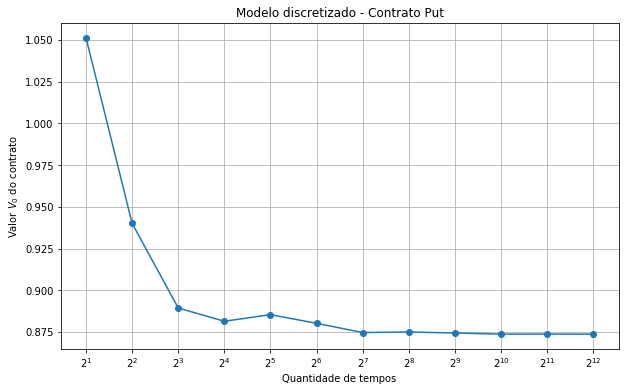

In [7]:
plt.figure(figsize=(10,6))
plt.plot(ns,vs_put,marker='o')
plt.title('Modelo discretizado - Contrato Put')
plt.xticks(ns,labels=lbls)
plt.yticks()
plt.xlabel('Quantidade de tempos')
plt.ylabel('Valor ${V_0}$ do contrato')
plt.grid()
plt.show()

### Atividade 2

In [8]:
def path_values(s0, t, u, d, probs):
    Si = s0
    S = []
    
    # definindo u e d e neutra-riscos
    p_til = probs[0]
    q_til = probs[1]
    t_int = int(t**(-1))
    
    # esperança e desvio padrão do modelo
    mi = p_til*u + q_til * d
    sig = np.sqrt(p_til*q_til*(u-d)**2)
    
    # esperança e desvio padrão discretizados
    mi_t = mi**t
    sig_t = np.sqrt((mi**2 + sig**2)**t - (mi**2)**t) 
    # up & down & taxa de juros discretizados
    u_disc = mi_t + sig_t
    d_disc = mi_t - sig_t
    
    for i in range(t_int):
        rnd = np.random.rand()
        if rnd < p_til:
            Si *= u_disc
        else:
            Si *= d_disc
        S.append(Si)
    return S

def monte_carlo(s,k,tipo=0):
    def payoff(s):
    ## Faz um call
        if tipo == 0:
             aux = [i - k if i > k else 0 for i in s]
        ## Faz um put
        else:
             aux = [k - i if k > i else 0 for i in s]
        return aux
    return payoff(s)

In [9]:
## Exemplo de Monte Carlo com t = 1/4 Call
vs_mc_call = []
for i in range(5000):
    vs_mc_call.append(monte_carlo(path_values(4,1/4,2,1/2,[1/2,1/2]),5,0))
v0_mc_call = np.mean([np.mean(i) for i in vs_mc_call])
print(v0_mc_call)

0.7034103415047368


In [10]:
## Exemplo de Monte Carlo com t = 1/4 Put
vs_mc_put = []
for i in range(5000):
    vs_mc_put.append(monte_carlo(path_values(4,1/4,2,1/2,[1/2,1/2]),5,1))
v0_mc_put = np.mean([np.mean(i) for i in vs_mc_put])
print(v0_mc_put)

1.0787617878550155


In [11]:
vs_mc_call = []
vs_mc_put = []
v0_mc_call = []
v0_mc_put = []
for n in range(1,13):
    for i in range(10000):
        vs_mc_put.append(monte_carlo(path_values(4,1/2**n,2,1/2,[1/2,1/2]),5,1))
        vs_mc_call.append(monte_carlo(path_values(4,1/2**n,2,1/2,[1/2,1/2]),5,0))
    v0_mc_call.append([np.mean(i) for i in vs_mc_call])
    v0_mc_put.append([np.mean(i) for i in vs_mc_put])
v0_med_mc_call = [np.mean(i) for i in v0_mc_call]
v0_med_mc_put = [np.mean(i) for i in v0_mc_put]

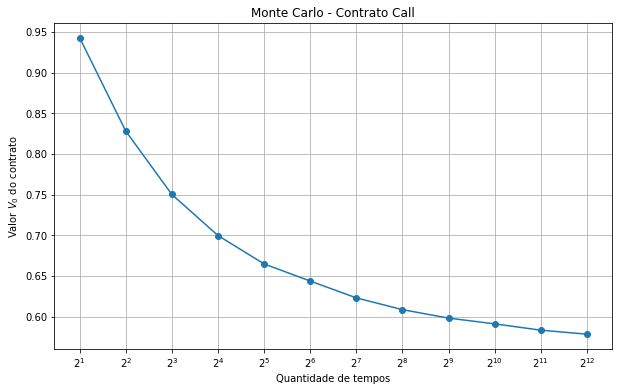

In [12]:
plt.figure(figsize=(10,6))
plt.plot(ns,v0_med_mc_call,marker='o')
plt.title('Monte Carlo - Contrato Call')
plt.xticks(ns,labels=lbls)
plt.yticks()
plt.xlabel('Quantidade de tempos')
plt.ylabel('Valor ${V_0}$ do contrato')
plt.grid()
plt.show()

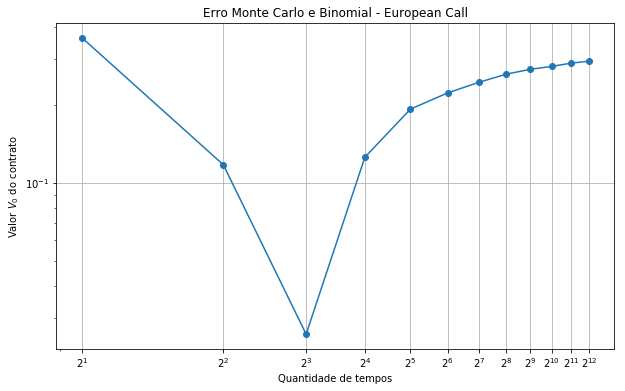

In [13]:
erro_call = [abs(i-j) for (i,j) in zip(v0_med_mc_call,vs_call)]
plt.figure(figsize=(10,6))
plt.loglog(ns,erro_call,marker='o')
plt.title('Erro Monte Carlo e Binomial - European Call')
plt.xticks(ns,labels=lbls)
plt.yticks()
plt.xlabel('Quantidade de tempos')
plt.ylabel('Valor ${V_0}$ do contrato')
plt.grid()
plt.show()

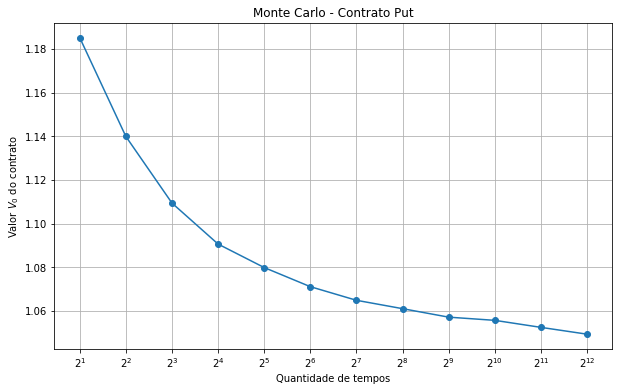

In [16]:
plt.figure(figsize=(10,6))
plt.plot(ns,v0_med_mc_put,marker='o')
plt.title('Monte Carlo - Contrato Put')
plt.xticks(ns,labels=lbls)
plt.yticks()
plt.xlabel('Quantidade de tempos')
plt.ylabel('Valor ${V_0}$ do contrato')
plt.grid()
plt.show()

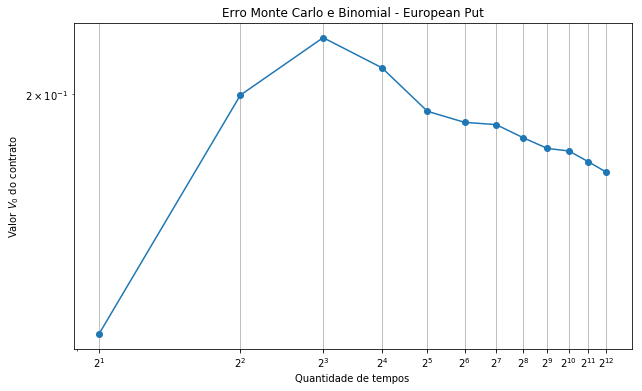

In [14]:
erro_put = [abs(i-j) for (i,j) in zip(v0_med_mc_put,vs_put)]
plt.figure(figsize=(10,6))
plt.loglog(ns,erro_put,marker='o')
plt.title('Erro Monte Carlo e Binomial - European Put')
plt.xticks(ns,labels=lbls)
plt.yticks()
plt.xlabel('Quantidade de tempos')
plt.ylabel('Valor ${V_0}$ do contrato')
plt.grid()
plt.show()

### Atividade 3

In [32]:
def path_values(s0, t, u, d, probs):
    Si = s0
    S = []
    
    # definindo u e d e neutra-riscos
    p_til = probs[0]
    q_til = probs[1]
    t_int = int(t**(-1))
    
    # esperança e desvio padrão do modelo
    mi = p_til*u + q_til * d
    sig = np.sqrt(p_til*q_til*(u-d)**2)
    
    # esperança e desvio padrão discretizados
    mi_t = mi**t
    sig_t = np.sqrt((mi**2 + sig**2)**t - (mi**2)**t) 
    # up & down & taxa de juros discretizados
    u_disc = mi_t + sig_t
    d_disc = mi_t - sig_t
    
    for i in range(t_int):
        rnd = np.random.rand()
        if rnd < p_til:
            Si *= u_disc
        else:
            Si *= d_disc
        S.append(Si)
    return S

def monte_carlo_asian(s,k,tipo=0):
    def payoff(s):
        soma = sum(s)
        #print(soma)
        ## Faz um call
        if tipo == 0:
             aux = [1/len(s)*(soma) - k if (1/len(s)*(soma)) > k else 0 for i in s]
        return aux
    return payoff(s)

In [61]:
## Exemplo de Monte Carlo com path dependent
vs_mc_call = []
ts = np.linspace(100,20000,50)
v0s = []
for j in ts:
    #aux = []
    for i in range(int(j)):
        vs_mc_call.append(monte_carlo_asian(path_values(4,1/4,2,1/2,[1/2,1/2]),5,0))
    v0_mc_call = np.mean([np.mean(i) for i in vs_mc_call])
    v0s.append(v0_mc_call)

[0.4375963652392393, 0.5430647987100987, 0.5659954994665015, 0.5887257301647619, 0.6063966674512364, 0.6007000475802122, 0.59761603881015, 0.5999644474723044, 0.5976725740468002, 0.603708748419119, 0.5977466652728642, 0.5996175339288562, 0.6020554644317307, 0.602865690827988, 0.6024661399474587, 0.6000492886401212, 0.5983613964338844, 0.5979717109927528, 0.5975483331239534, 0.5959104950513261, 0.5963203347462082, 0.596151614168296, 0.5956277630799244, 0.5966015807360663, 0.595932506843876, 0.5955148715654366, 0.597069574112133, 0.5962722420278928, 0.5948332512707466, 0.5938287254192948, 0.5933789118258452, 0.5939371717689256, 0.5926664383095693, 0.5926750699858094, 0.5927138671174984, 0.5921893638611629, 0.5916076288860549, 0.5921668737877549, 0.5917103705536981, 0.5919960225949764, 0.5930161021609842, 0.5936357141924494, 0.5938755724718722, 0.5936678269710457, 0.5940933579439398, 0.593703826512015, 0.5937905229117144, 0.5936783432336281, 0.593402765992101, 0.5933350639634067]


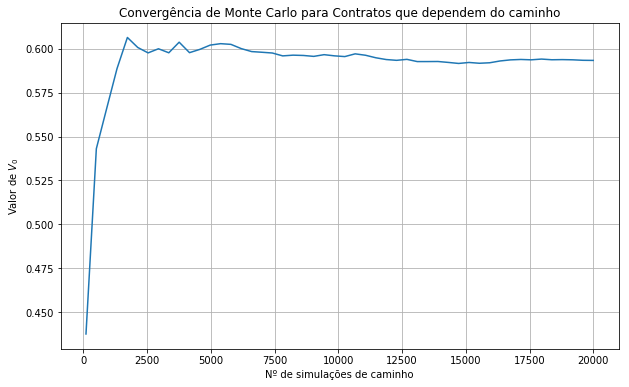

In [66]:
plt.figure(figsize=(10,6))
plt.plot(ts,v0s)
plt.title('Convergência de Monte Carlo para Contratos que dependem do caminho')
plt.xlabel('Nº de simulações de caminho')
plt.ylabel('Valor de $V_0$')
plt.grid()
plt.show()